### Octavio Revetria 232745

# Reinforcement Learning Tarea 3 - Métodos Monte Carlo (blackjack)

En este laboratorio vamos a explorar los métodos de Monte Carlo (Capítulo 5 del libro de Sutton y Barto). Para esto, vamos a volver a utilizar un ambiente definido en [Gymnasium](https://gymnasium.farama.org/index.html), es el caso esta vez de otro ambiente sencillo: el juego de Blackjack. El [ambiente de gymnasium](https://gymnasium.farama.org/environments/toy_text/blackjack/) esta inspirado por el ejemplo 5.1 del libro, ya esta incluido en gym, por lo que no es necesario crearlo desde cero. 


## Descripción del ambiente a usar

### Reglas del juego

Es un juego de cartas donde el objetivo es obtener cartas que sumen lo más cercano a 21 posible, sin pasarnos. Jugamos contra un dealer fijo unicamente.

Reglas:
   
- Las cartas con figuras (Jotas, Reinas y Reyes) tienen valor de 10.
- Los Ases pueden valer 11 ó 1, cuando vale 11 se lo llama "usable" y es su valor por defecto.
- En este caso jugamos con un mazo infinito (con reemplazo).
- El dealer comienza con una carta boca arriba y una boca abajo.
- El jugador puede pedir una carta (HIT) hasta que decida quedarse (STICK) o exceeda los 21 puntos (BUST).
- Cuando el jugador se queda (STICK), el dealer muestra su carta boca abajo y pide cartas hasta que su suma sea 17 o más.
- Si el dealer se pasa de 21, el jugador gana. En caso contrario, gana quien tenga la suma más cerca de 21.

### Implementación en Gymnasium

- La reward por perder es -1, por ganar es +1 y por pedir carta es 0. En caso de empate, la reward es 0.
- Cada observacion es una tupla que tiene: 
    - la suma del jugador
    - la carta boca arriba del dealer (1-10 donde 1 es un As)
    - True o False si el jugador tiene un As usable o no

Revisa el [ambiente en gymnasium](https://gymnasium.farama.org/environments/toy_text/blackjack/) para entender como funciona.


### A entregar

- Notebook con solución a los algoritmos presentados
- Analisis de la función de valor estimada para distinto número de episodios a visitar (ej: 100, 10000, 50000, 500000). Se busca que puedan demostrar entendimiento del algoritmo y sus resultados (Esperamos gráficas y analisis de las mismas). 
- Estimaciones de función de valor para otras politicas definidas por el estudiante (al menos una). 

In [1]:
import gymnasium as gym
from gymnasium.utils.play import play
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from Utils import plot_value_distribution, plot_Q_distribution

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


In [2]:
# Nos asegurams que las gráficas se muestren en el notebook
import matplotlib
%matplotlib inline

 Vemos el espacio de estado y acción del ambiente de blackjack.

In [3]:
# Crear el entorno de Blackjack
env = gym.make("Blackjack-v1", render_mode="rgb_array")
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [4]:
# vemos un ejemplo de observación
obs, _ = env.reset()
print(f"Jugador: {obs[0]}, Dealer: {obs[1]}, As usable: {obs[2]} ")

Jugador: 13, Dealer: 10, As usable: 0 


Simulemos una partida de blackjack.

In [5]:
# Caso de prueba
state,_ = env.reset()
print('initial state:', state)

while True:
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    print('state:', state, 'reward:', reward, 'done:', done)
    if done or truncated:
        print(f'Reward: {reward}')                
        break

initial state: (10, 6, 0)
state: (10, 6, 0) reward: 1.0 done: True
Reward: 1.0


## Predicción de la función de valor ($V$ y $Q$)

Vamos a implementar el algoritmo de Monte Carlo para estimar las funciones de valor $V$ y $Q$ para el ambiente de blackjack asi como algunas variantes (first visit, every visit, exploración inicial, etc).

Para ello primero vamos a definir una politica: Si suma 20 o más, se queda (STICK), si no pide carta (HIT). Esta política es la que se usa en el ejemplo del libro.

In [6]:
STICK = 0
HIT = 1
       
## Politica Sutton & Barto
def sutton_policy(observation):
    sum, _, _ = observation
    return STICK if sum >= 20 else HIT

### Generación de episodios

Vamos a implementar una función que genere episodios de la política definida. La función va a recibir el ambiente y la política y va a devolver una lista de transiciones (estado, acción, reward, next_state).

In [7]:
def generate_episode(policy, env):
    """
    Genera un episodio utilizando la política dada.
    Args:
        policy: Función que toma un estado y devuelve una acción.
        env: Entorno de OpenAI Gym.
    Returns:
        episode: Lista de tuplas (estado, acción, recompensa, siguiente_estado).
    """
    episode = []
    state, _ = env.reset()
    done = False

    while not done:
        action = policy(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward, next_state))
        state = next_state
        done = terminated or truncated

    return episode

In [8]:
# lo probamos
episode = generate_episode(sutton_policy, env)
print("Episodio generado:")
for state, action, reward, next_state in episode:
    print(f"Estado: {state}, Acción: {action} ({'Hit' if action == 1 else 'Stick'}), Recompensa: {reward}, Siguiente estado: {next_state}")

Episodio generado:
Estado: (18, 9, 1), Acción: 1 (Hit), Recompensa: 0.0, Siguiente estado: (18, 9, 0)
Estado: (18, 9, 0), Acción: 1 (Hit), Recompensa: 0.0, Siguiente estado: (19, 9, 0)
Estado: (19, 9, 0), Acción: 1 (Hit), Recompensa: -1.0, Siguiente estado: (29, 9, 0)


### First-Visit MC para estimar $V$

El primer algoritmo que vamos a implementar es el de Monte Carlo First Visit. Este algoritmo estima la función de valor $V$ para una política dada.

$$
\begin{aligned}
\textbf{Algoritmo First-Visit MC (para estimar }v_\pi\text{):} \\[6pt]
\textbf{Entrada:} & \quad \pi,\ \text{política a evaluar.}\\
& \quad \text{(Se asume que podemos generar episodios con } \pi\text{.)}\\[6pt]
\textbf{Inicializar:} 
& \quad V(s) \in \mathbb{R}, \quad \forall\, s \in S \quad (\text{valores arbitrarios})\\
& \quad \text{Returns}(s) \leftarrow \varnothing, \quad \forall\, s \in S.\\[6pt]
\textbf{Bucle (por cada episodio):} 
& \\[-2pt]
& \quad \text{Generar un episodio siguiendo } \pi: (S_0, A_0, R_1, \ldots, S_T).\\
& \quad G \leftarrow 0.\\
& \quad \textbf{para } t = T-1,\, T-2,\, \ldots,\, 0:\\
& \quad\quad G \leftarrow \gamma\,G + R_{t+1}.\\
& \quad\quad \textbf{si } S_t \notin \{S_0, S_1, \ldots, S_{t-1}\}:\\
& \quad\quad\quad \text{Returns}(S_t) \leftarrow \text{Returns}(S_t) \cup \{G\}.\\
& \quad\quad\quad V(S_t) \leftarrow \text{average}\bigl(\text{Returns}(S_t)\bigr).\\[6pt]
\textbf{Retornar:} 
& \quad V.
\end{aligned}
$$

> Tip: con [defaultdict](https://docs.python.org/3/library/collections.html#defaultdict-objects) podemos definir un diccionario con un valor por defecto.

In [9]:
A = defaultdict(float)
B = defaultdict(int)
C = defaultdict(lambda: [])

print(A[999])
print(B[999])
print(C[999])

0.0
0
[]


In [10]:
lista = [1,2,3,4,5]
print(lista[0:-2])

[1, 2, 3]


In [11]:
def first_visit_mc_prediction(policy, env, number_episodes, gamma=1.0):
    V = defaultdict(float)
    returns = defaultdict(lambda: [])
    for _ in tqdm(range(number_episodes)):
        episode = generate_episode(policy, env)
        T = len(episode)
        t = T
        G = 0
        states = [state for state, _, _, _ in episode]
        for state, _, reward, _ in episode[::-1]:
            t -= 1
            G = (gamma * G) + reward
            if not state in states[:t]:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
    return V

In [12]:
sab_value = first_visit_mc_prediction(sutton_policy, env, number_episodes=50_000)

100%|██████████| 50000/50000 [00:04<00:00, 10382.17it/s]


In [13]:
print(sab_value)

defaultdict(<class 'float'>, {(18, 10, 0): np.float64(-0.7042513863216266), (15, 10, 0): np.float64(-0.6314229249011858), (13, 10, 0): np.float64(-0.5835040983606558), (14, 1, 0): np.float64(-0.6918367346938775), (11, 1, 0): np.float64(-0.2175925925925926), (20, 8, 0): np.float64(0.7726027397260274), (16, 8, 0): np.float64(-0.6124031007751938), (8, 8, 0): np.float64(-0.5634920634920635), (20, 7, 1): np.float64(0.776595744680851), (14, 7, 1): np.float64(-0.3492063492063492), (17, 8, 0): np.float64(-0.7371323529411765), (20, 10, 0): np.float64(0.4432647644326476), (12, 10, 0): np.float64(-0.5553157042633567), (12, 8, 0): np.float64(-0.6078431372549019), (21, 3, 1): np.float64(0.9818181818181818), (20, 5, 0): np.float64(0.6653171390013495), (21, 1, 1): np.float64(0.6401673640167364), (18, 1, 1): np.float64(-0.38666666666666666), (16, 1, 1): np.float64(-0.42857142857142855), (15, 6, 0): np.float64(-0.5948827292110874), (11, 6, 0): np.float64(0.09130434782608696), (17, 6, 0): np.float64(-0.

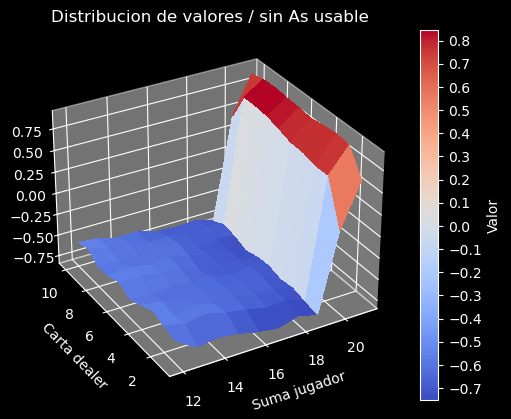

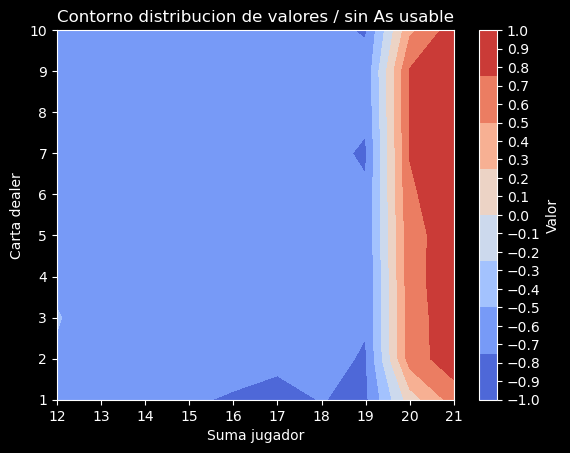

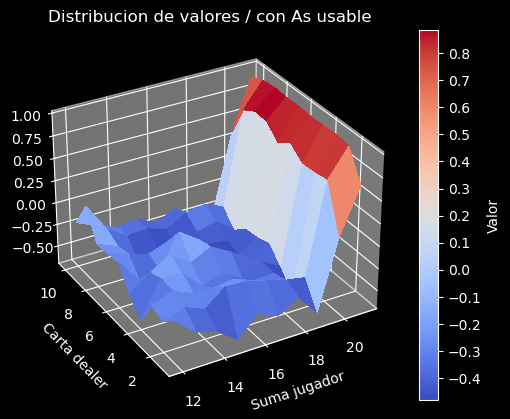

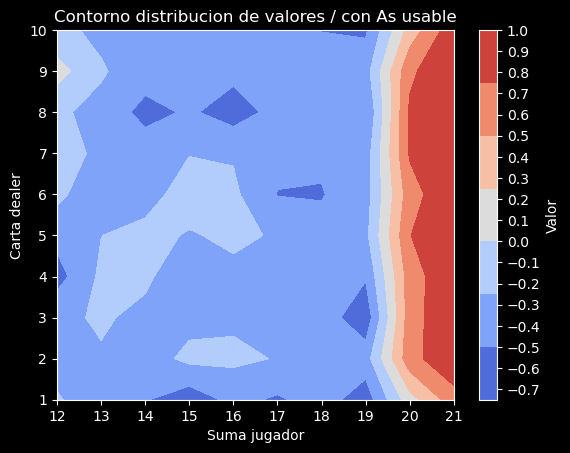

In [14]:
plot_value_distribution(sab_value)

Una estrategía más elaborada, basada en Edward Thorp, que se basa en la carta del dealer y la suma del jugador. La idea es que si el dealer tiene una carta baja (2-6) el jugador se queda si tiene 12 o más, si no pide carta. Si el dealer tiene una carta alta (7-10) el jugador se queda si tiene 17 o más, si no pide carta.

100%|██████████| 50000/50000 [00:04<00:00, 12086.68it/s]


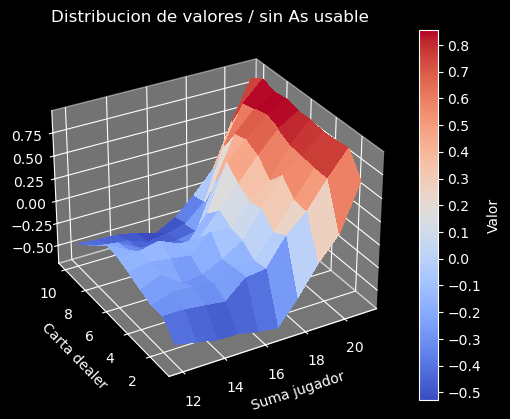

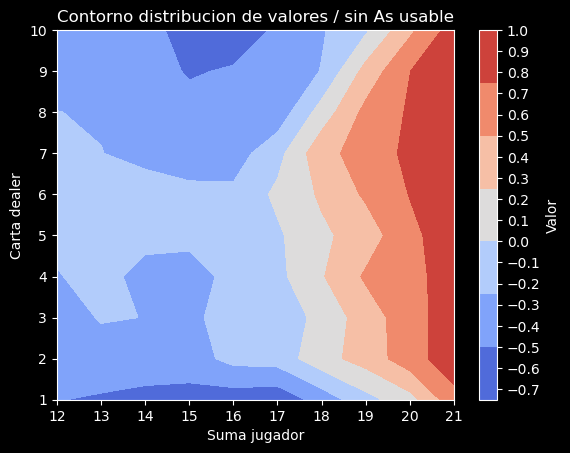

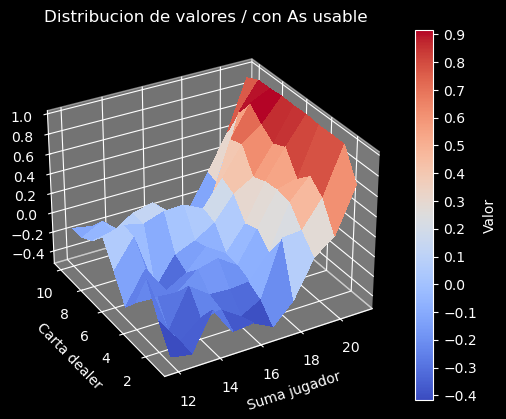

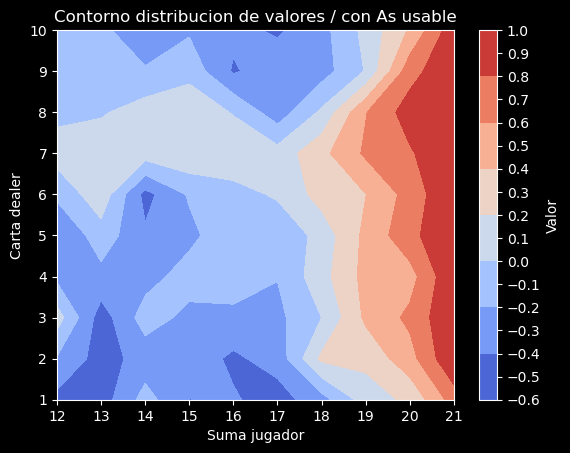

In [15]:
def thorp_policy(observation):
    player_sum, dealer_card, usable_ace = observation
    # Si la suma del jugador es menor a 12, nunca se pasa, así que se pide carta.
    if player_sum < 12:
        return HIT
    # Para sumas entre 12 y 16, se aconseja quedarse si el dealer muestra una carta débil (2 a 6),
    # ya que el dealer tiene más probabilidad de pasarse.
    if 12 <= player_sum <= 16:
        if 2 <= dealer_card <= 6:
            return STICK
        else:
            return HIT
    # Con una suma de 17 o mayor, es recomendable plantarse.
    return STICK

thorp_value = first_visit_mc_prediction(thorp_policy, env, number_episodes=50_000)

plot_value_distribution(thorp_value)

> 1) ¿Qué valores se esperan de $V$ si implementamos el algoritmo de Monte Carlo Every Visit en este caso? ¿Por qué?
> 2) Definir una política diferente que tenga en cuenta el As usable y estimar su función de valor. 

#### Respuesta 1
Se esperan los mismos valores para V. Ya que, por la naturaleza del blackjack, no se puede repetir un estado en un mismo episodio. Esto es porque al pedir un carta, me es imposible volver a terminar en un mismo estado. Siempre algo cambia, o aumenta mi suma o utilizo mi as usable. Por lo tanto, el every visit debería dar los mismo valores que el first visit.

#### Respuesta 2
Se implementa política con as usable.

100%|██████████| 50000/50000 [00:04<00:00, 11780.97it/s]


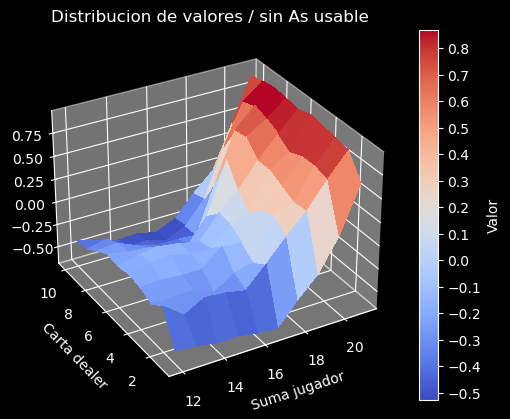

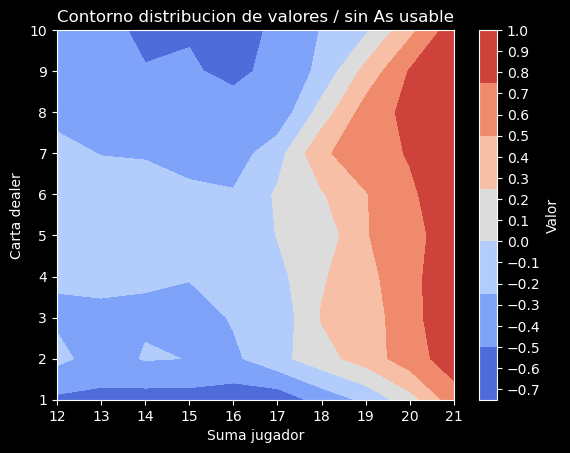

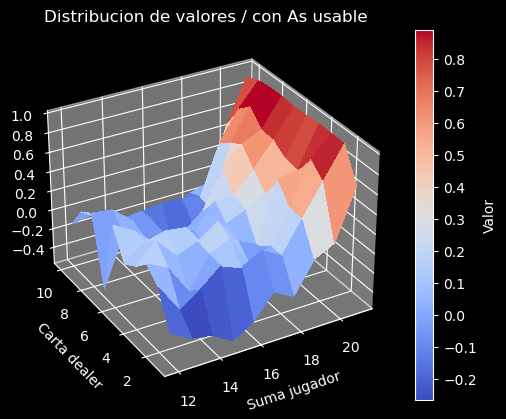

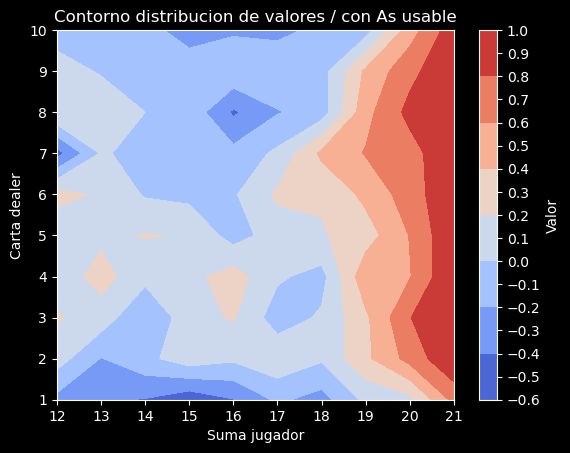

In [16]:
def politica_mejorada(observation):
    player_sum, dealer_card, usable_ace = observation
    # Si la suma del jugador es menor a 12, nunca se pasa, así que se pide carta.
    if player_sum < 12:
        return HIT
    # Con as usable el margen es mayor por eso hasta 18 seguimos pidiendo.
    if usable_ace:
        if 12 <= player_sum <= 18:
            return HIT
        else:
            return STICK
    # Para sumas entre 12 y 16, se aconseja quedarse si el dealer muestra una carta débil (2 a 6),
    # ya que el dealer tiene más probabilidad de pasarse.
    elif 12 <= player_sum <= 16:
        if 2 <= dealer_card <= 6:
            return STICK
        else:
            return HIT
    # Con una suma de 17 o mayor, es recomendable plantarse y sin as recomendable plantarse.
    return STICK

mejorada_value = first_visit_mc_prediction(politica_mejorada, env, number_episodes=50_000)

plot_value_distribution(mejorada_value)

### First-Visit MC para estimar $Q$ con exploración inicial

Cuando queremos estimar la función de valor $Q$ para una política dada, tenemos el problema de que no tenemos una política exploratoria. Por ende podría no visitar todos los estados y acciones. Para resolver esto, podemos usar la técnica de exploración inicial donde se elige un estado aleatorio ($S_0$) y una acción aleatoria ($A_0$) y se juega un episodio desde ahí. Esto nos permite explorar el espacio de estados y acciones. 

> Notar que la política no cambia, solo se elige un estado y acción aleatorios para empezar a jugar.

> El desafío en Gymnasium es que no podemos elegir el estado inicial. Pero podemos intentar "hacer trampa" y modificar su estado interno. Esto no es recomendable, pero para fines de este laboratorio lo vamos a hacer.


$$
\begin{aligned}
\textbf{Algoritmo First-Visit MC (para estimar }Q(s,a)\text{ con exploración inicial):} \\[6pt]
\textbf{Entrada:} & \quad \pi,\ \text{la política a evaluar.}\\[6pt]
\textbf{Inicializar:} & \quad Q(s,a) \in \mathbb{R}\quad \text{(valores arbitrarios)},\quad \forall\, s \in S,\; a \in A(s),\\
& \quad \text{Returns}(s,a) \leftarrow \varnothing,\quad \forall\, s \in S,\; a \in A(s).\\[6pt]
\textbf{Loop (por cada episodio):} & \\[-2pt]
& \quad \text{Elegir al azar un estado inicial } S_0 \in S \text{ y una acción } A_0 \in A(S_0).\\
& \quad \text{Generar un episodio siguiendo } \pi: (S_0, A_0, R_1, S_1, A_1, \ldots, S_T).\\
& \quad G \leftarrow 0.\\
& \quad \textbf{para } t = T-1,\; T-2,\; \ldots,\; 0: \\
& \quad\quad G \leftarrow \gamma\,G + R_{t+1}.\\
& \quad\quad \textbf{si } (S_t,A_t) \notin \{(S_0,A_0),\,(S_1,A_1),\,\ldots,\,(S_{t-1},A_{t-1})\}: \\
& \quad\quad\quad \text{Returns}(S_t,A_t) \leftarrow \text{Returns}(S_t,A_t) \cup \{G\}.\\
& \quad\quad\quad Q(S_t,A_t) \leftarrow \text{average}\Bigl(\text{Returns}(S_t,A_t)\Bigr).\\[6pt]
\textbf{Retornar:} & \quad Q.
\end{aligned}
$$


In [17]:
from gymnasium.envs.toy_text.blackjack import BlackjackEnv

# https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/blackjack.py
# https://gymnasium.farama.org/api/wrappers/#gymnasium.Wrapper
class BlackjackEnvWrapper(BlackjackEnv):
    def set_state(self, state):
        """
        Fija el estado inicial deseado.
        state: (player_sum, dealer_card, usable_ace)
        """
        player_sum, dealer_card, usable = state
        # Configuramos la mano del jugador
        if usable:
            # Para tener un as usable, construimos una mano que contenga un 1 y otra carta que
            # haga que la suma (1 + otra carta + 10) sea player_sum.
            card = player_sum - 11
            # Aseguramos que la otra carta esté en el rango permitido (1 a 10)
            card = max(1, min(card, 10))
            self.player = [1, card]
        else:
            # Sin as usable, buscamos dos cartas que sumen player_sum
            # Esto es una simplificación; se podría mejorar para asegurarse de no incluir un 1.
            card1 = player_sum // 2
            card2 = player_sum - card1
            card1 = max(2, min(card1, 10))
            card2 = max(2, min(card2, 10))
            self.player = [card1, card2]
        
        # Configuramos la mano del dealer de modo que su carta visible sea la deseada.
        self.dealer = [dealer_card, np.random.randint(1, 11)]


In [18]:
def generate_episode_with_initial_exploration(policy, env):
    """
    Genera un episodio utilizando la política dada, con exploración inicial.
    """
    episode = []
    env.reset()
    
    # Escogemos un estado inicial aleatorio
    player_sum = np.random.randint(12, 22)   # suma entre 12 y 21
    dealer_card = np.random.randint(1, 11)     # carta del dealer entre 1 y 10
    usable = np.random.randint(0, 2)           # 0 o 1
    state = (player_sum, dealer_card, usable)
    
    # Usamos el método del wrapper para fijar el estado
    env.set_state(state)
    state = env._get_obs()
    
    first_action = True
    done = False
    while not done:
        if first_action:
            action = env.action_space.sample()
            first_action = False
        else:
            action = policy(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward, next_state))
        state = next_state
        done = terminated or truncated

    return episode



In [19]:
env_wrapped = BlackjackEnvWrapper(env)
generate_episode_with_initial_exploration(politica_mejorada, env_wrapped)

[((15, 9, 0), np.int64(0), 1.0, (15, 9, 0))]

In [20]:
def first_visit_mc_q_prediction_ie(policy, env, number_episodes, gamma=1.0):
    Q = defaultdict(float)
    returns = defaultdict(lambda: [])
    for _ in tqdm(range(number_episodes)):
        episode = generate_episode_with_initial_exploration(policy, env)
        T = len(episode)
        t = T
        G = 0
        action_states = [(state, action) for state, action, _, _ in episode]
        for state, action, reward, _ in episode[::-1]:
            t -= 1
            G = (gamma * G) + reward
            if not (state, action) in action_states[:t]:
                returns[state, action].append(G)
                Q[state, action] = np.mean(returns[state, action])
    return Q

In [21]:
sab_q_value = first_visit_mc_q_prediction_ie(sutton_policy, env_wrapped, number_episodes=50_000)

100%|██████████| 50000/50000 [00:04<00:00, 11105.02it/s]


In [22]:
sab_q_value[(21, 5, 0), 0]

np.float64(0.8669527896995708)

In [23]:
sab_q_value[(21, 5, 0), 1] # Por que da esto?

0.0

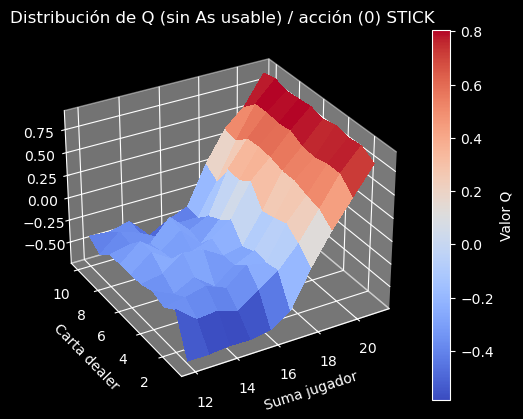

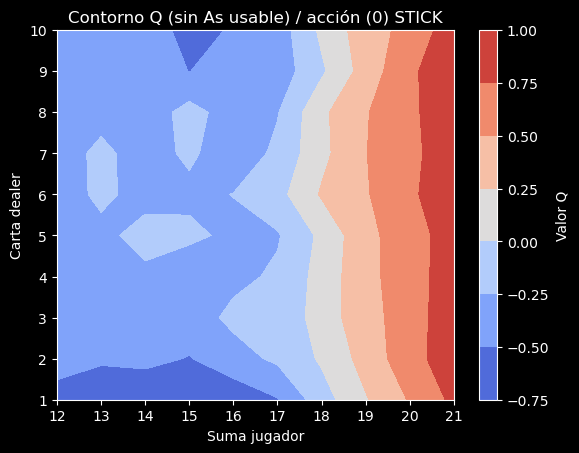

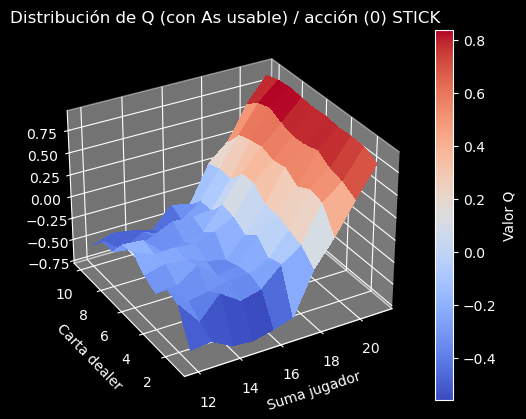

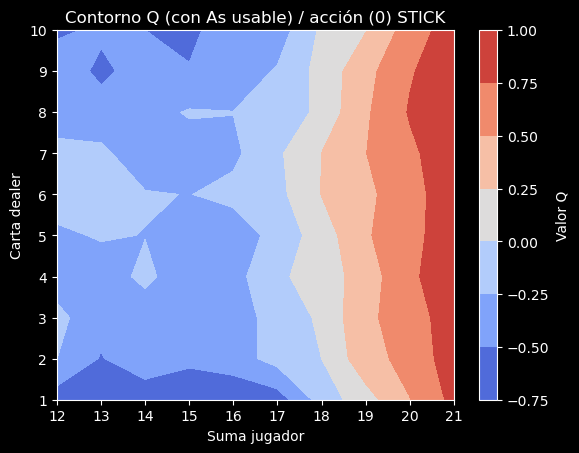

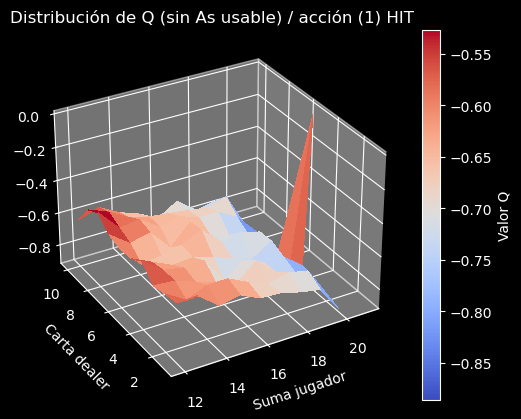

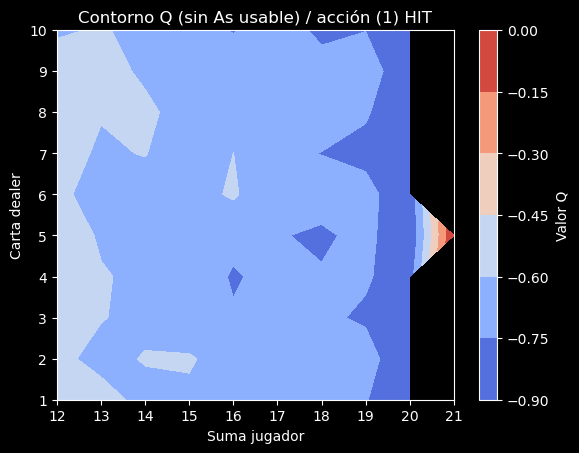

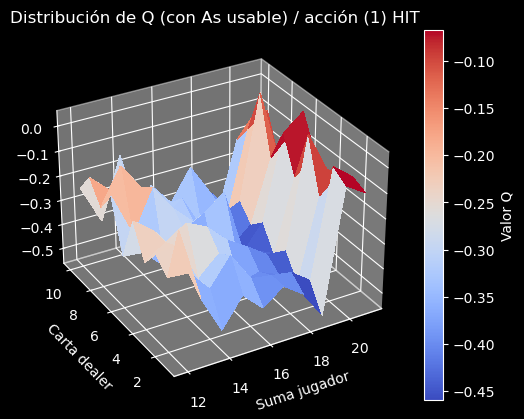

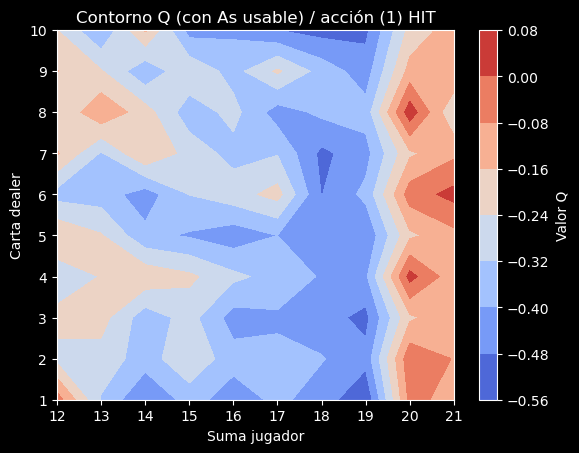

In [24]:
plot_Q_distribution(sab_q_value)

## **Tareas**

1. Implementar el algoritmo de Monte Carlo First Visit para estimar la función de valor $V$ y $Q$ para la política definida.
2. Comparar las estimaciones de la función de valor para distintos episodios (ej: 100, 10000, 50000, 500000). 
3. Elaborar una política diferente que tenga en cuenta el As usable y estimar su función de valor.
4. [extra] Implementar el algoritmo un algoritmo de control Monte Carlo para estimar la politica óptima. Puede ser MC ES para control (cap 5.3 del libro) o on-policy MC control (cap 5.4 del libro). Graficar resultados y comparar con politicas anteriores. ¿ Puede asegurar que "la casa siempre gana" ? 🎰

In [25]:
thorp_q_value_5_000 = first_visit_mc_q_prediction_ie(thorp_policy, env_wrapped, number_episodes=5_000)
thorp_q_value_50_000 = first_visit_mc_q_prediction_ie(thorp_policy, env_wrapped, number_episodes=50_000)
thorp_q_value_500_000 = first_visit_mc_q_prediction_ie(thorp_policy, env_wrapped, number_episodes=500_000)

100%|██████████| 500000/500000 [01:19<00:00, 6267.67it/s] 


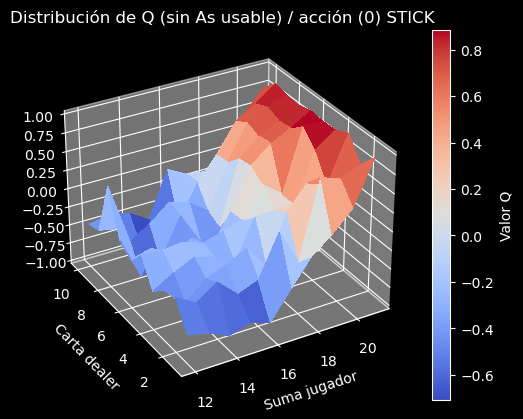

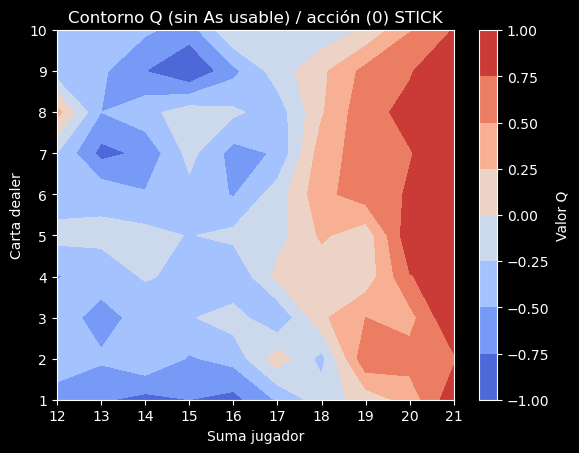

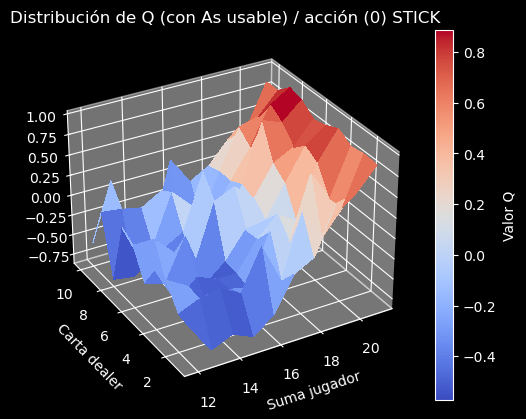

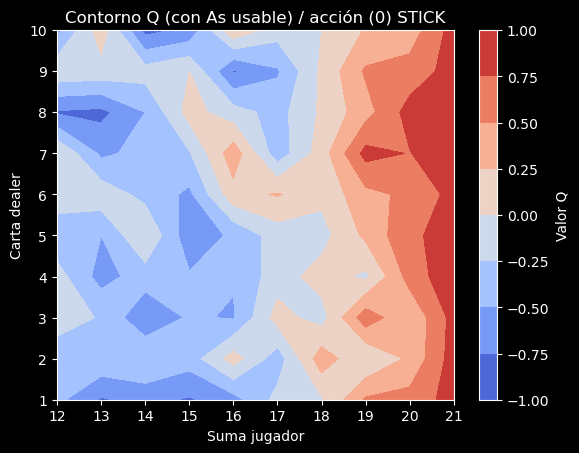

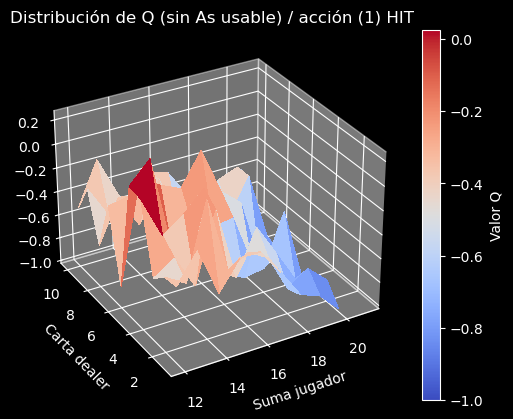

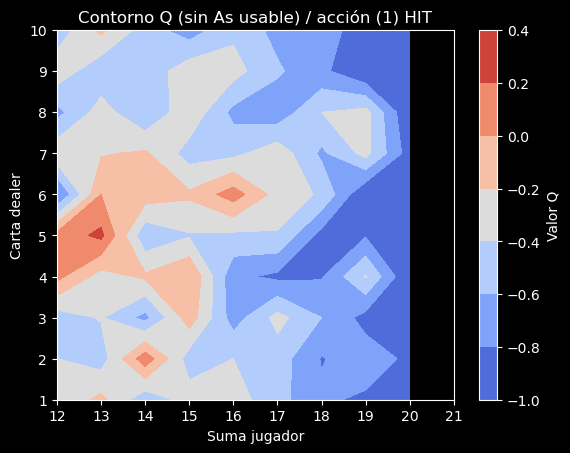

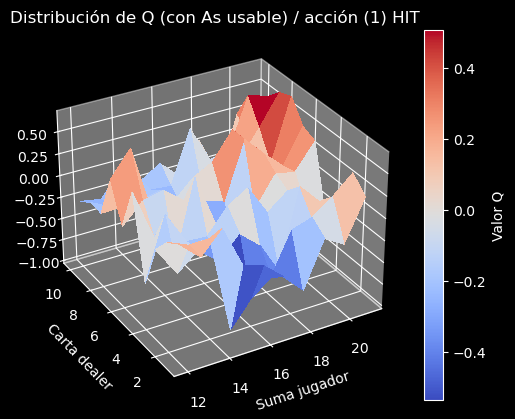

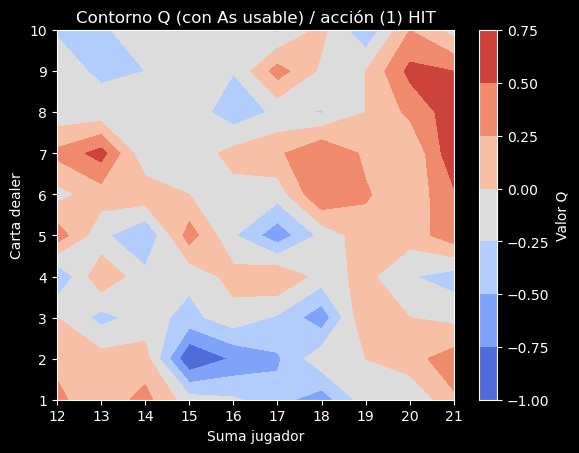

In [26]:
plot_Q_distribution(thorp_q_value_5_000)

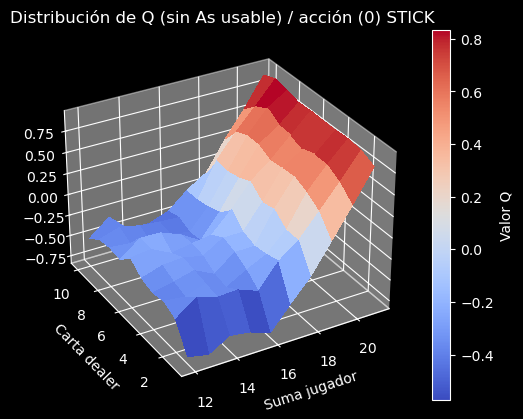

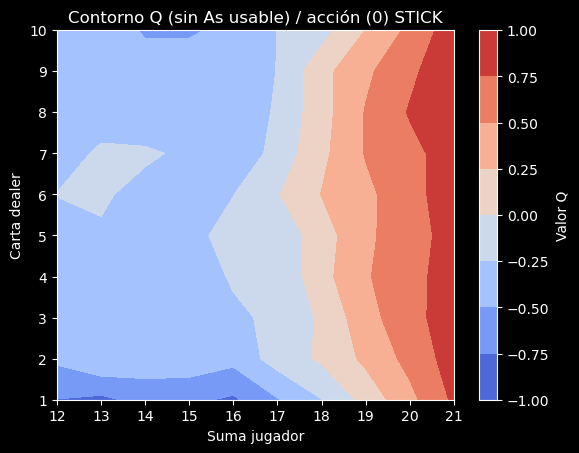

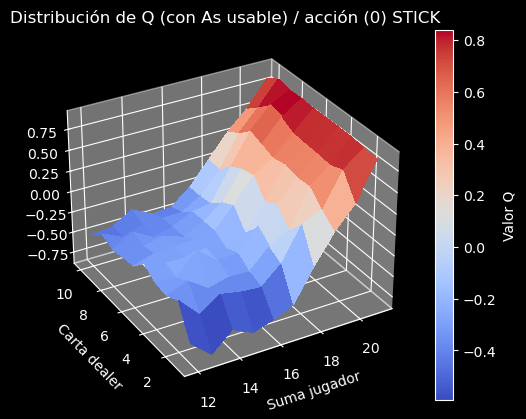

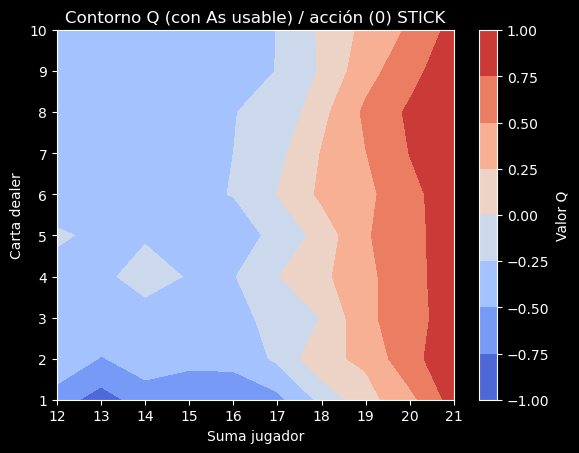

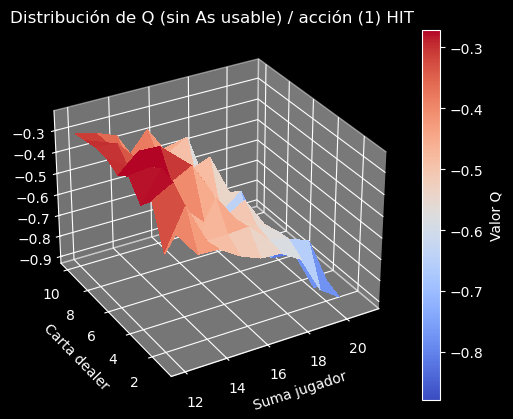

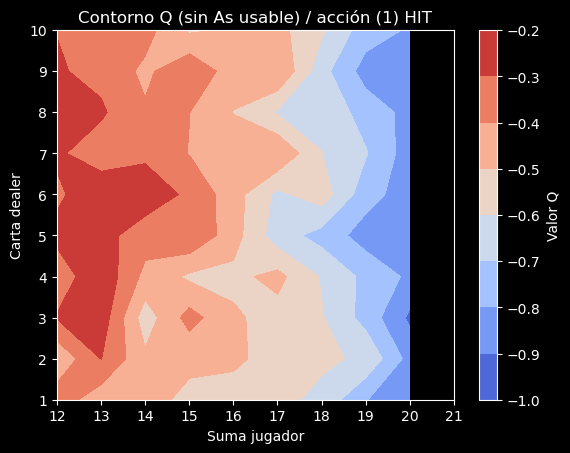

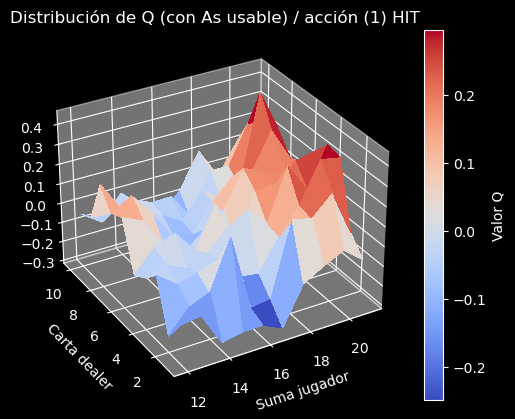

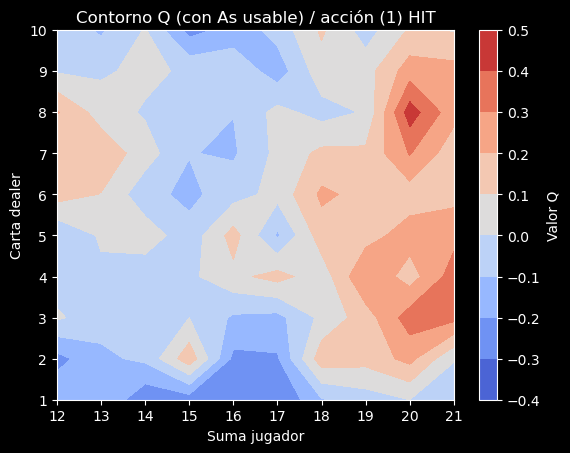

In [27]:
plot_Q_distribution(thorp_q_value_50_000)


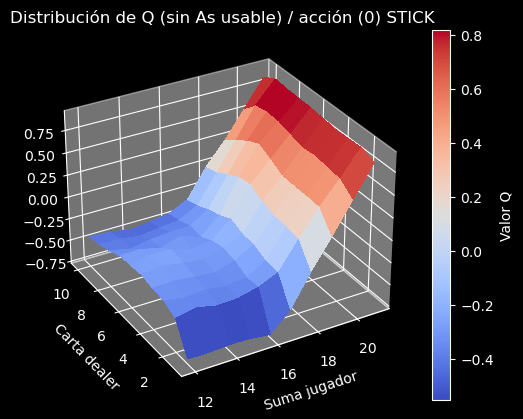

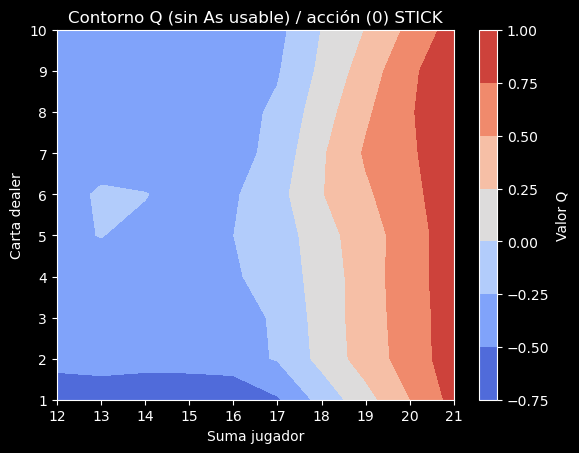

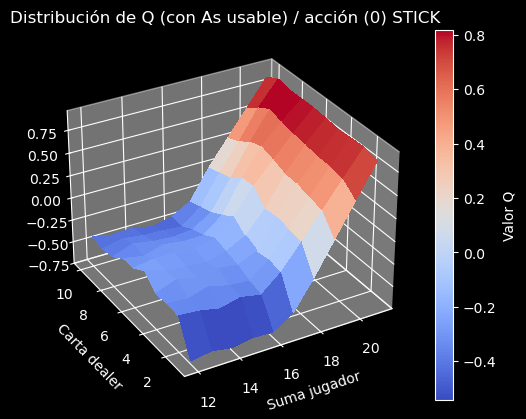

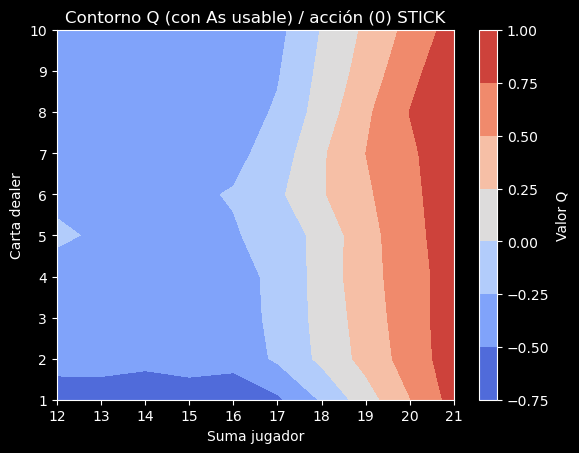

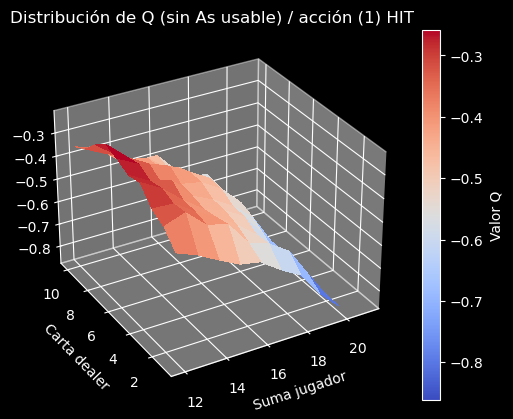

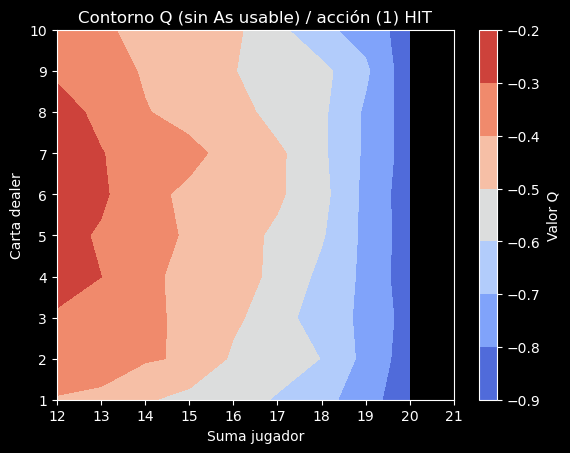

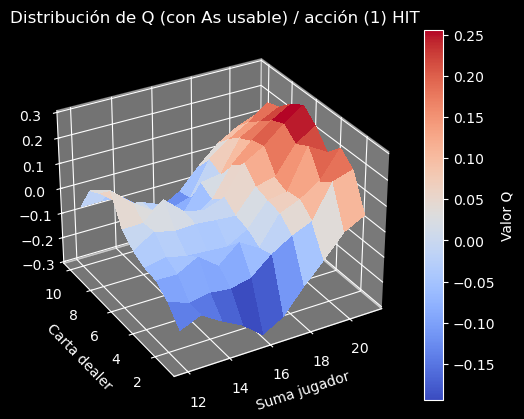

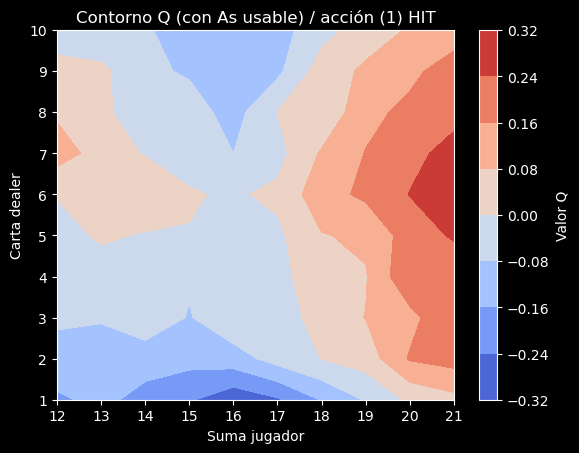

In [28]:
plot_Q_distribution(thorp_q_value_500_000)

#### Conclusión
Al aumentar el número de episodios, las estimaciones quedan delimitadas en zonas más evidentes.

Con 5000 episodios por ejemplo, no nos queda muy claro viendo las etimaciones si teniendo 19 el jugador es una acción conveniente plantarse. 

Sin embargo, al realizar la estimación con 500000 episodios. 
Queda en evidencia que es una acción con estimación favorable para el jugador.

In [29]:
thorp_q_value_5_000[(19, 5, 0), 0]

np.float64(0.08695652173913043)

In [30]:
thorp_q_value_500_000[(19, 5, 0), 0]

np.float64(0.37980582524271844)

In [31]:
mejorada_q_value_500_000 = first_visit_mc_q_prediction_ie(politica_mejorada, env_wrapped, number_episodes=500_000)

100%|██████████| 500000/500000 [01:23<00:00, 6008.07it/s] 


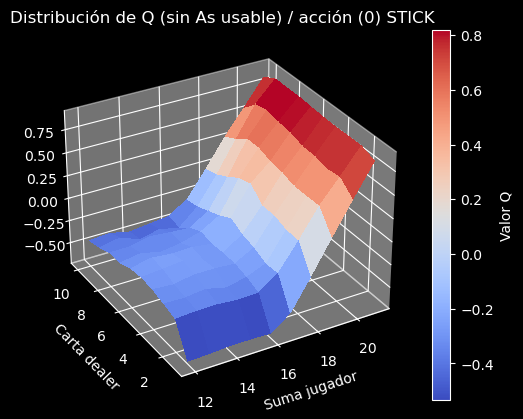

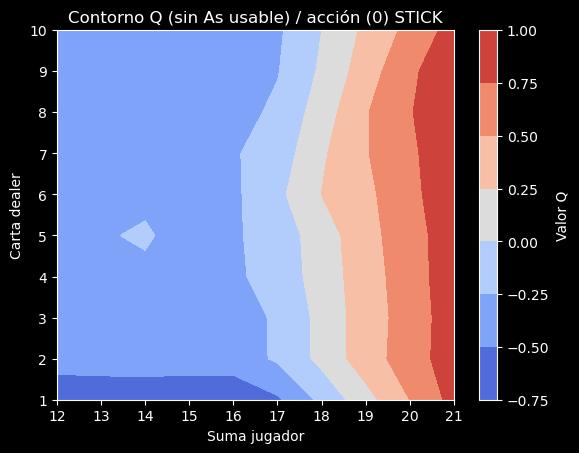

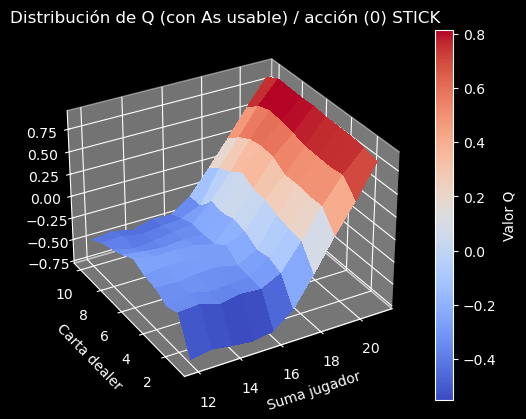

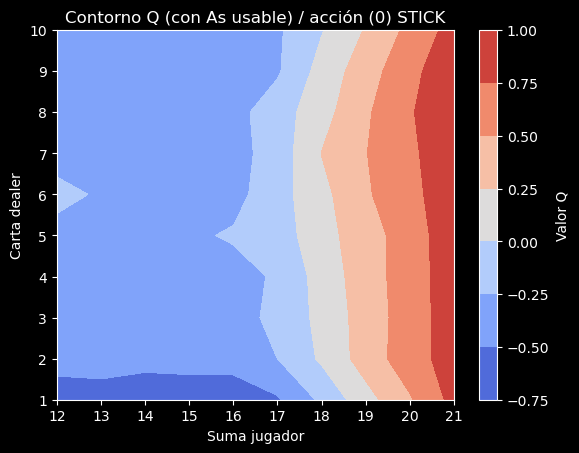

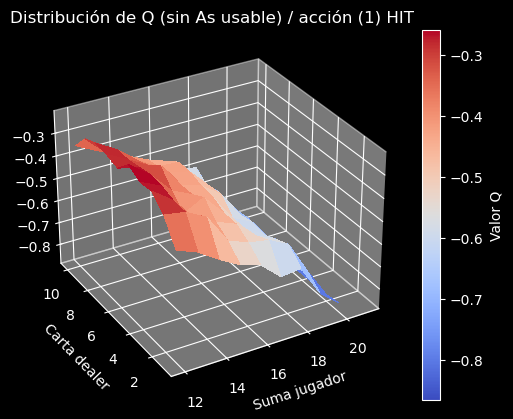

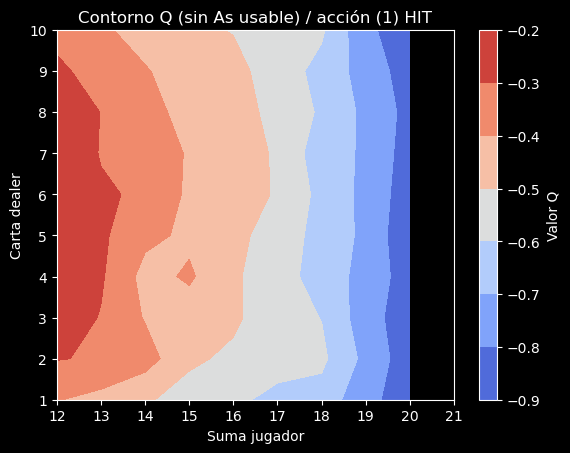

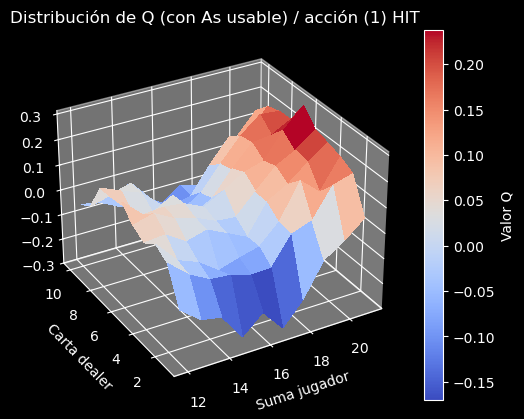

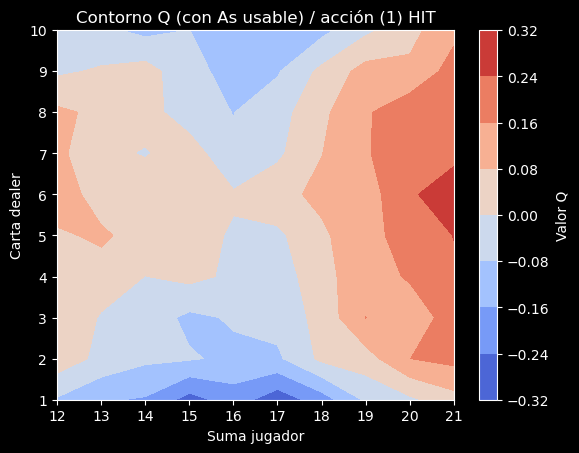

In [32]:
plot_Q_distribution(mejorada_q_value_500_000)

### Conclusión

La estrategia de Thorp ignoraba el as usable, llevándonos a plantarnos con sumas subóptimas incluso teniendo margen para pedir sin riesgo de pasarnos. 

Un ejemplo claro es un 13 con as usable contra una carta baja del crupier (2-6). La nueva política indica que pedir en esta situación, resulta mucho más ventajoso que plantarse según la estimación hecha con Thorp.